In [1]:
%run ../input/python-recipes/dhtml.py
dhtml('File Writing')

In [2]:
%%writefile pictogram_photo_classify.py
import pandas as pd,numpy as np,tensorflow as tf
import os,seaborn as sn,pylab as pl
from IPython.display import display
from tensorflow.keras.preprocessing \
import image as tkimg
from tensorflow.keras.datasets import cifar10
from IPython.core.magic import register_line_magic
import tensorflow_hub as th
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc

img_size1,img_size2=32,96
cmap1,cmap2='spring','autumn'
fw='weights.best.hdf5'
names1=[['pictogram','contour','sketch'],
        ['flower','bird','butterfly','tree',
         'plane','crane','dog','horse',
         'deer','truck','car','cat',
         'frog','ship','fish','house']]
names2=[['plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck']]

def images2array(files_path,img_size,
                 preprocess=False,grayscale=False):
    files_list=sorted(os.listdir(files_path))
    n,img_array=len(files_list),[]
    for i in range(n):
        if i%round(.1*n)==0:
            print('=>',end='',flush=True)
        img_path=files_path+files_list[i]
        if preprocess:
            img=tkimg.load_img(
                img_path,grayscale=grayscale)
            img=tkimg.img_to_array(img)
            img=tkimg.smart_resize(
                img,(img_size,img_size))
        else:
            img=tkimg.load_img(
                img_path,target_size=(img_size,img_size))
            img=tkimg.img_to_array(img)
        img=np.expand_dims(img,axis=0)/255
        img_array.append(img)
    return np.array(np.vstack(img_array),
                    dtype='float32')

def labels2array(files_path):
    files_list=sorted(os.listdir(files_path))
    files_split=np.array([el.split('_') 
                          for el in files_list])
    num_labels=files_split.shape[1]-1
    labels=[files_split[:,i] 
            for i in range(num_labels)]
    labels=np.array(labels).astype('int32')
    for i in range(num_labels):
        label_set=list(set(labels[i]))
        replace_dict=\
        dict(zip(label_set,
                 list(range(len(label_set)))))
        labels[i]=[replace_dict.get(x,x) 
                   for x in labels[i]]
    return labels

def get_data(files_path,img_size,names1,names2,
             preprocess=False,grayscale=False):
    images=images2array(files_path,img_size,
                        preprocess,grayscale)
    labels=labels2array(files_path)
    n=len(labels[0][labels[0]==0])
    images=images[:n]; labels=labels[1][:n]
    cond1=np.where([l in names2[0] for l in names1[1]])[0]
    cond2=np.where([l in cond1 for l in labels])[0]
    images=images[cond2]; labels=labels[cond2]
    rd=dict(zip([names1[1].index(names2[0][i])
                 for i in range(10)],range(10)))
    labels=[rd.get(el,el) for el in labels]
    labels=np.array(labels,dtype='int32')
    return images,labels

def get_cifar():
    (images,labels),(_,_)=cifar10.load_data()
    images=np.array(images,dtype='float32')/255
    labels=np.array(labels,dtype='int32').reshape(-1)
    return images,labels

def data2nnarrays(images,labels,num,cmap,names=names2):
    N=num; n=int(.1*N)
    shuffle_ids=np.arange(images.shape[0])
    np.random.RandomState(12).shuffle(shuffle_ids)
    shuffle_ids=shuffle_ids[:N]
    images=images[shuffle_ids]
    labels=labels[shuffle_ids]
    x_test,x_valid,x_train=\
    images[:n],images[n:2*n],images[2*n:]
    y_test,y_valid,y_train=\
    labels[:n],labels[n:2*n],labels[2*n:]
    print('data outputs: ')
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [x_train.dtype,x_valid.dtype,x_test.dtype],
                     [y_train.shape,y_valid.shape,y_test.shape],
                     [y_train.dtype,y_valid.dtype,y_test.dtype]],
                    columns=['train','valid','test'],
                    index=['image shape','image type',
                           'label shape','label type'])
    display(df)
    print('distribution of labels: ')
    df=pd.DataFrame(labels,columns=['label'])
    df['name']=[names[0][l] for l in labels]
    fig=pl.figure(figsize=(10,5))    
    ax=fig.add_subplot(1,1,1)
    sn.countplot(x='name',data=df,
                 palette=cmap,alpha=.5,ax=ax)
    pl.show()       
    return x_train,x_valid,x_test,\
           y_train,y_valid,y_test

def display_images(images,labels,n,names=names2):
    fig=pl.figure(figsize=(10,n//2))
    randch=np.random.choice(
        images.shape[0],size=n,replace=False)
    for i,idx in enumerate(randch):
        ax=fig.add_subplot(
            n//5,5,i+1,xticks=[],yticks=[])
        ax.imshow(images[idx])
        label=labels[idx]
        name=names[0][label]
        ax.set_title('{} => {}'\
                     .format(str(label),str(name)),
                     fontsize=10)
    pl.show()
    
def img_resize(x,img_size=img_size2):       
    x=tf.image.resize(x,[img_size,img_size])
    return x.numpy()

def get_resized_data(data):
    [rx_train,rx_valid,rx_test]=\
    [img_resize(el) for el in data[:3]]
    [y_train,y_valid,y_test]=data[3:]
    print([rx_train.shape,rx_train.dtype])
    print('Label: ',names2[0][y_valid[100]])
    pl.figure(figsize=(1,1))
    pl.xticks([]); pl.yticks([])
    pl.imshow(rx_valid[100]); pl.show()
    return rx_train,rx_valid,rx_test,\
           y_train,y_valid,y_test

def get_mixed_data(data1,data2):
    data=[np.vstack([data1[i],data2[i]])
          for i in range(3)]+\
         [np.hstack([data1[i+3],data2[i+3]])
          for i in range(3)]
    [x_train,x_valid,x_test,
     y_train,y_valid,y_test]=data
    for [x,y] in [[x_train,y_train],
                  [x_valid,y_valid],
                  [x_test,y_test]]:
        N=len(y); shuffle_ids=np.arange(N)
        np.random.RandomState(23).shuffle(shuffle_ids)
        x,y=x[shuffle_ids],y[shuffle_ids]
    return x_train,x_valid,x_test,\
           y_train,y_valid,y_test

def cnn_model(data):
    [x_train,x_valid,x_test,
     y_train,y_valid,y_test]=data
        
    model=Sequential()
    model.add(tkl.Conv2D(32,(5,5),padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(tkl.Activation('relu'))
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.Activation('relu'))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.GlobalAveragePooling2D())    
    model.add(tkl.Dense(1024,activation='relu'))
    model.add(tkl.Dropout(.5))         
    model.add(tkl.Dense(10))
    model.add(tkl.Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                     patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                     save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                       patience=5,factor=.8)
    history=model.fit(x_train,y_train,epochs=100,
                      batch_size=64,verbose=2,
                      validation_data=(x_valid,y_valid),
                      callbacks=[checkpointer,
                                 early_stopping,
                                 lr_reduction])
    return model,history

def hub_model(data):
    [rx_train,rx_valid,rx_test,
     ry_train,ry_valid,ry_test]=data
    handle_base="mobilenet_v2_050_96"
    mhandle="https://tfhub.dev/google/imagenet/{}/feature_vector/4"\
    .format(handle_base)
    
    model=tf.keras.Sequential([
        tf.keras.layers.Input((img_size2,img_size2,3),
                              name='input'),
        th.KerasLayer(mhandle,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(10,activation='softmax')])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy') 
    early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                     patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                     save_best_only=True)
    lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                       patience=5,factor=.8)
    history=model.fit(rx_train,ry_train,epochs=50,
                      batch_size=64,verbose=2,
                      validation_data=(rx_valid,ry_valid),
                      callbacks=[checkpointer,
                                 early_stopping,
                                 lr_reduction])
    return model,history

def history_plot(fit_history,fig_size,color):
    pl.style.use('seaborn-whitegrid')
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size))
    ax1=fig.add_subplot(311)
    dfkeys.iloc[:,[0,2]].plot(
        ax=ax1,color=['slategray',color])
    ax2=fig.add_subplot(312)
    dfkeys.iloc[:,4].plot(ax=ax2,color=color)
    pl.legend()
    ax3=fig.add_subplot(313)
    dfkeys.iloc[:,[1,3]].plot(
        ax=ax3,color=['slategray',color])
    pl.show();

Writing pictogram_photo_classify.py


In [3]:
dhtml('Data Loading & Preprocessing')

In [4]:
%run pictogram_photo_classify.py

In [5]:
dhtml('Pictogram Data')

In [6]:
files_path1='../input/art-pictogram/'+\
            'pictograms/'

In [7]:
images1,labels1=\
get_data(files_path1,img_size1,names1,names2,
         preprocess=False,grayscale=False)

=>=>=>=>=>=>=>=>=>=>=>

In [8]:
num1=images1.shape[0]; num1

1169

data outputs: 


,train,valid,test
image shape,"(937, 32, 32, 3)","(116, 32, 32, 3)","(116, 32, 32, 3)"
image type,float32,float32,float32
label shape,"(937,)","(116,)","(116,)"
label type,int32,int32,int32


distribution of labels: 


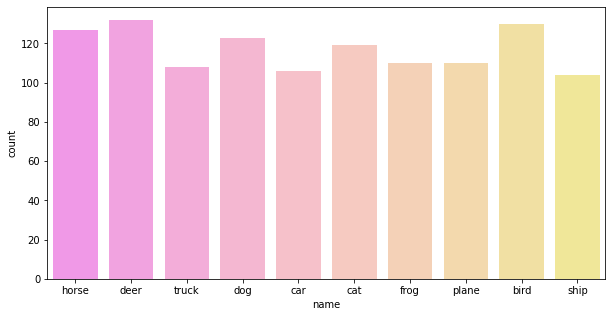

In [9]:
x_train1,x_valid1,x_test1,\
y_train1,y_valid1,y_test1=\
data2nnarrays(images1,labels1,num1,cmap1)

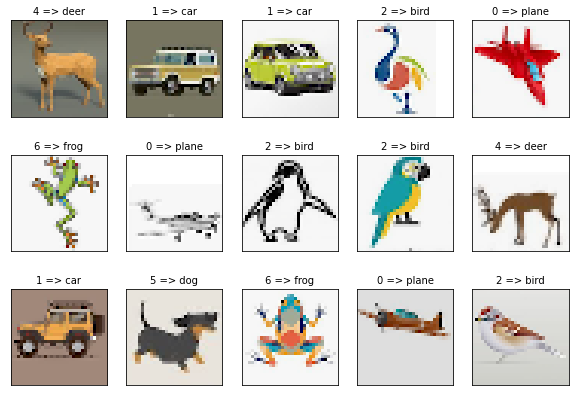

In [10]:
display_images(x_train1,y_train1,15)

In [11]:
dhtml('CIFAR Data')

In [12]:
images2,labels2=get_cifar()

170500096/170498071 [==============================] - 18s 0us/step


data outputs: 


,train,valid,test
image shape,"(937, 32, 32, 3)","(116, 32, 32, 3)","(116, 32, 32, 3)"
image type,float32,float32,float32
label shape,"(937,)","(116,)","(116,)"
label type,int32,int32,int32


distribution of labels: 


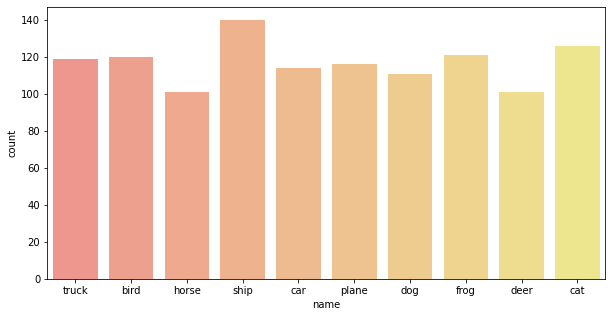

In [13]:
x_train2,x_valid2,x_test2,\
y_train2,y_valid2,y_test2=\
data2nnarrays(images2,labels2,num1,cmap2)

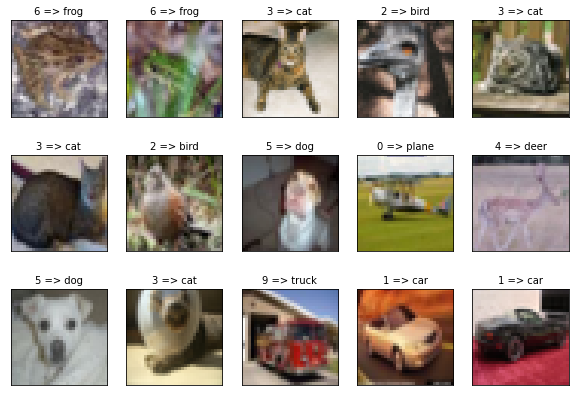

In [14]:
display_images(x_train2,y_train2,15)

In [15]:
dhtml('Resized Data')

[(937, 96, 96, 3), dtype('float32')]
Label:  bird


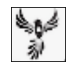

In [16]:
rx_train1,rx_test1,rx_valid1,\
ry_train1,ry_valid1,ry_test1=\
get_resized_data([x_train1,x_test1,x_valid1,
                  y_train1,y_valid1,y_test1])

[(937, 96, 96, 3), dtype('float32')]
Label:  horse


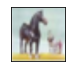

In [17]:
rx_train2,rx_test2,rx_valid2,\
ry_train2,ry_valid2,ry_test2=\
get_resized_data([x_train2,x_test2,x_valid2,
                  y_train2,y_valid2,y_test2])

In [18]:
dhtml('Mixed Data')

In [19]:
x_train0,x_test0,x_valid0,\
y_train0,y_valid0,y_test0=\
get_mixed_data([x_train1,x_test1,x_valid1,
                y_train1,y_valid1,y_test1],
               [x_train2,x_test2,x_valid2,
                y_train2,y_valid2,y_test2])

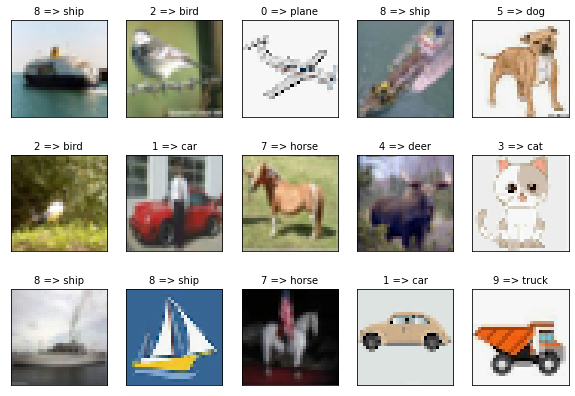

In [20]:
display_images(x_train0,y_train0,15)

In [21]:
rx_train0,rx_test0,rx_valid0,\
ry_train0,ry_valid0,ry_test0=\
get_mixed_data([rx_train1,rx_test1,rx_valid1,
                ry_train1,ry_valid1,ry_test1],
               [rx_train2,rx_test2,rx_valid2,
                ry_train2,ry_valid2,ry_test2])

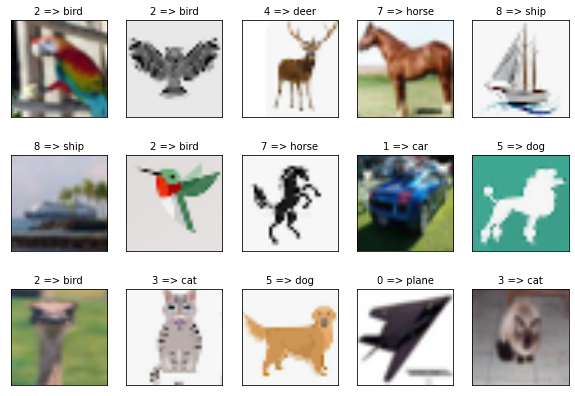

In [22]:
display_images(rx_train0,ry_train0,15)

In [23]:
dhtml('Data Dictionary')

In [24]:
data_dict=\
{'0':[x_train0,x_valid0,x_test0,
      y_train0,y_valid0,y_test0],
 '1':[x_train1,x_valid1,x_test1,
      y_train1,y_valid1,y_test1],
 '2':[x_train2,x_valid2,x_test2,
      y_train2,y_valid2,y_test2],
 'r0':[rx_train0,rx_valid0,rx_test0,
      ry_train0,ry_valid0,ry_test0],
 'r1':[rx_train1,rx_valid1,rx_test1,
      ry_train1,ry_valid1,ry_test1],
 'r2':[rx_train2,rx_valid2,rx_test2,
      ry_train2,ry_valid2,ry_test2]}
[el.shape for el in data_dict['r2']]

[(937, 96, 96, 3), (116, 96, 96, 3), (116, 96, 96, 3), (937,), (116,), (116,)]

In [25]:
dhtml('NN Models')
dhtml('Pictogram Data')

In [26]:
model,history=cnn_model(data_dict['1'])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.29544, saving model to weights.best.hdf5
15/15 - 0s - loss: 2.3028 - accuracy: 0.1078 - val_loss: 2.2954 - val_accuracy: 0.0776
Epoch 2/100

Epoch 00002: val_loss did not improve from 2.29544
15/15 - 0s - loss: 2.2892 - accuracy: 0.1291 - val_loss: 2.3004 - val_accuracy: 0.1207
Epoch 3/100

Epoch 00003: val_loss improved from 2.29544 to 2.29159, saving model to weights.best.hdf5
15/15 - 0s - loss: 2.2708 - accuracy: 0.1590 - val_loss: 2.2916 - val_accuracy: 0.1293
Epoch 4/100

Epoch 00004: val_loss improved from 2.29159 to 2.25546, saving model to weights.best.hdf5
15/15 - 0s - loss: 2.2590 - accuracy: 0.1644 - val_loss: 2.2555 - val_accuracy: 0.1207
Epoch 5/100

Epoch 00005: val_loss improved from 2.25546 to 2.20894, saving model to weights.best.hdf5
15/15 - 0s - loss: 2.2238 - accuracy: 0.1761 - val_loss: 2.2089 - val_accuracy: 0.2155
Epoch 6/100

Epoch 00006: val_loss improved from 2.20894 to 2.11461, saving model to weights.

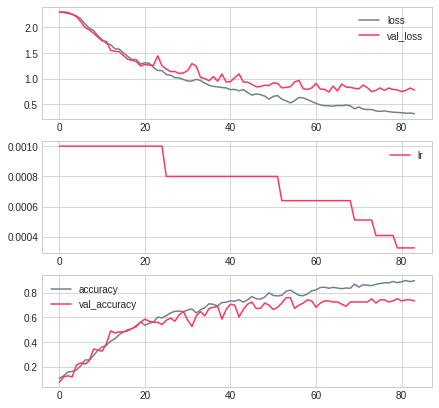

In [27]:
history_plot(history,7,c1)

In [28]:
model.load_weights(fw)
model.evaluate(x_test1,y_test1)

4/4 [==============================] - 0s 4ms/step - loss: 1.3086 - accuracy: 0.5776


[1.3086029291152954, 0.5775862336158752]

In [29]:
model,history=hub_model(data_dict['r1'])

Epoch 1/50

Epoch 00001: val_loss improved from inf to 2.03949, saving model to weights.best.hdf5
15/15 - 2s - loss: 1.4017 - accuracy: 0.5891 - val_loss: 2.0395 - val_accuracy: 0.6121
Epoch 2/50

Epoch 00002: val_loss did not improve from 2.03949
15/15 - 1s - loss: 0.3810 - accuracy: 0.8911 - val_loss: 2.0418 - val_accuracy: 0.6638
Epoch 3/50

Epoch 00003: val_loss did not improve from 2.03949
15/15 - 1s - loss: 0.3241 - accuracy: 0.9136 - val_loss: 2.2879 - val_accuracy: 0.6552
Epoch 4/50

Epoch 00004: val_loss did not improve from 2.03949
15/15 - 1s - loss: 0.1981 - accuracy: 0.9541 - val_loss: 2.3823 - val_accuracy: 0.6810
Epoch 5/50

Epoch 00005: val_loss did not improve from 2.03949
15/15 - 1s - loss: 0.1493 - accuracy: 0.9701 - val_loss: 2.6893 - val_accuracy: 0.6897
Epoch 6/50

Epoch 00006: val_loss did not improve from 2.03949

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
15/15 - 1s - loss: 0.1218 - accuracy: 0.9723 - val_loss: 2.9793 - val_ac

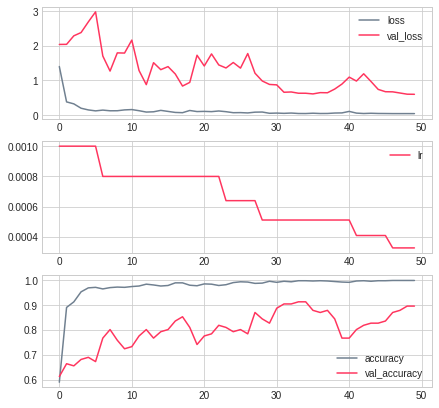

In [30]:
history_plot(history,7,c1)

In [31]:
model.load_weights(fw)
model.evaluate(rx_test1,ry_test1)

4/4 [==============================] - 0s 22ms/step - loss: 0.8494 - accuracy: 0.8534


[0.8494035005569458, 0.8534482717514038]

In [32]:
dhtml('CIFAR Data')

In [33]:
model,history=cnn_model(data_dict['2'])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.27144, saving model to weights.best.hdf5
15/15 - 0s - loss: 2.2923 - accuracy: 0.1238 - val_loss: 2.2714 - val_accuracy: 0.1207
Epoch 2/100

Epoch 00002: val_loss did not improve from 2.27144
15/15 - 0s - loss: 2.1961 - accuracy: 0.1686 - val_loss: 2.2742 - val_accuracy: 0.1983
Epoch 3/100

Epoch 00003: val_loss improved from 2.27144 to 2.22946, saving model to weights.best.hdf5
15/15 - 0s - loss: 2.0829 - accuracy: 0.2017 - val_loss: 2.2295 - val_accuracy: 0.2241
Epoch 4/100

Epoch 00004: val_loss improved from 2.22946 to 2.17820, saving model to weights.best.hdf5
15/15 - 0s - loss: 2.0260 - accuracy: 0.2241 - val_loss: 2.1782 - val_accuracy: 0.1552
Epoch 5/100

Epoch 00005: val_loss improved from 2.17820 to 2.16040, saving model to weights.best.hdf5
15/15 - 0s - loss: 1.9678 - accuracy: 0.2327 - val_loss: 2.1604 - val_accuracy: 0.2069
Epoch 6/100

Epoch 00006: val_loss improved from 2.16040 to 2.10090, saving model to weights.

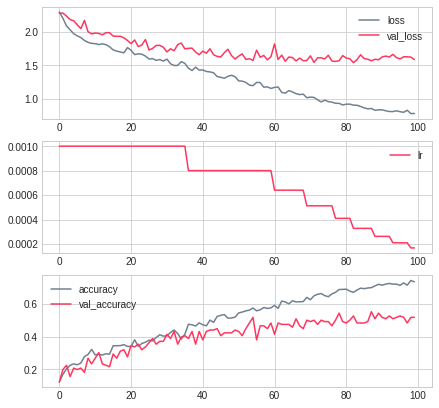

In [34]:
history_plot(history,7,c1)

In [35]:
model.load_weights(fw)
model.evaluate(x_test2,y_test2)

4/4 [==============================] - 0s 2ms/step - loss: 1.5682 - accuracy: 0.4655


[1.5681535005569458, 0.4655172526836395]

In [36]:
model,history=hub_model(data_dict['r2'])

Epoch 1/50

Epoch 00001: val_loss improved from inf to 2.29099, saving model to weights.best.hdf5
15/15 - 2s - loss: 1.5306 - accuracy: 0.5272 - val_loss: 2.2910 - val_accuracy: 0.5172
Epoch 2/50

Epoch 00002: val_loss did not improve from 2.29099
15/15 - 1s - loss: 0.5820 - accuracy: 0.8346 - val_loss: 3.6235 - val_accuracy: 0.4569
Epoch 3/50

Epoch 00003: val_loss did not improve from 2.29099
15/15 - 1s - loss: 0.3224 - accuracy: 0.9200 - val_loss: 5.2093 - val_accuracy: 0.4310
Epoch 4/50

Epoch 00004: val_loss did not improve from 2.29099
15/15 - 1s - loss: 0.2137 - accuracy: 0.9456 - val_loss: 4.4089 - val_accuracy: 0.5086
Epoch 5/50

Epoch 00005: val_loss did not improve from 2.29099
15/15 - 1s - loss: 0.2284 - accuracy: 0.9573 - val_loss: 2.7535 - val_accuracy: 0.5862
Epoch 6/50

Epoch 00006: val_loss did not improve from 2.29099

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
15/15 - 1s - loss: 0.1910 - accuracy: 0.9552 - val_loss: 4.0002 - val_ac

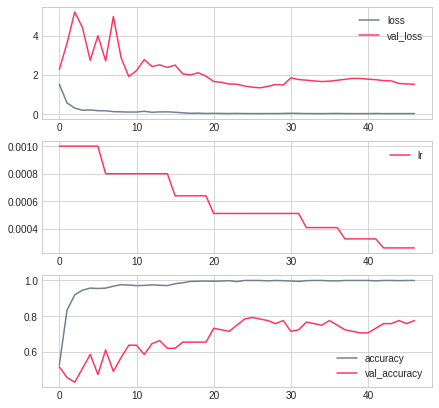

In [37]:
history_plot(history,7,c1)

In [38]:
model.load_weights(fw)
model.evaluate(rx_test2,ry_test2)

4/4 [==============================] - 0s 6ms/step - loss: 0.9041 - accuracy: 0.7759


[0.9040506482124329, 0.7758620977401733]

In [39]:
dhtml('Mixed Data')

In [40]:
model,history=cnn_model(data_dict['0'])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.29594, saving model to weights.best.hdf5
30/30 - 0s - loss: 2.3011 - accuracy: 0.1057 - val_loss: 2.2959 - val_accuracy: 0.1336
Epoch 2/100

Epoch 00002: val_loss improved from 2.29594 to 2.27986, saving model to weights.best.hdf5
30/30 - 0s - loss: 2.2653 - accuracy: 0.1537 - val_loss: 2.2799 - val_accuracy: 0.1595
Epoch 3/100

Epoch 00003: val_loss improved from 2.27986 to 2.19684, saving model to weights.best.hdf5
30/30 - 0s - loss: 2.1975 - accuracy: 0.1804 - val_loss: 2.1968 - val_accuracy: 0.1767
Epoch 4/100

Epoch 00004: val_loss improved from 2.19684 to 2.11028, saving model to weights.best.hdf5
30/30 - 0s - loss: 2.1262 - accuracy: 0.2012 - val_loss: 2.1103 - val_accuracy: 0.2026
Epoch 5/100

Epoch 00005: val_loss improved from 2.11028 to 2.00146, saving model to weights.best.hdf5
30/30 - 0s - loss: 2.0404 - accuracy: 0.2369 - val_loss: 2.0015 - val_accuracy: 0.2414
Epoch 6/100

Epoch 00006: val_loss did not improve fro

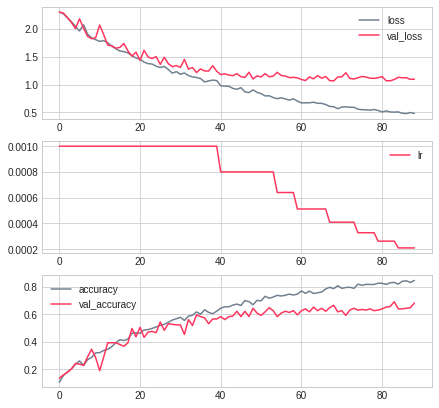

In [41]:
history_plot(history,7,c1)

In [42]:
model.load_weights(fw)
model.evaluate(x_test0,y_test0)

8/8 [==============================] - 0s 3ms/step - loss: 1.2861 - accuracy: 0.5690


[1.2860528230667114, 0.568965494632721]

In [43]:
model,history=hub_model(data_dict['r0'])

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.70847, saving model to weights.best.hdf5
30/30 - 3s - loss: 1.3614 - accuracy: 0.5854 - val_loss: 1.7085 - val_accuracy: 0.5905
Epoch 2/50

Epoch 00002: val_loss did not improve from 1.70847
30/30 - 1s - loss: 0.6145 - accuracy: 0.8138 - val_loss: 2.2272 - val_accuracy: 0.5560
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.70847
30/30 - 1s - loss: 0.4032 - accuracy: 0.8821 - val_loss: 2.6310 - val_accuracy: 0.6207
Epoch 4/50

Epoch 00004: val_loss did not improve from 1.70847
30/30 - 1s - loss: 0.2858 - accuracy: 0.9226 - val_loss: 3.9373 - val_accuracy: 0.5431
Epoch 5/50

Epoch 00005: val_loss did not improve from 1.70847
30/30 - 1s - loss: 0.3589 - accuracy: 0.9066 - val_loss: 2.8446 - val_accuracy: 0.5948
Epoch 6/50

Epoch 00006: val_loss did not improve from 1.70847

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
30/30 - 1s - loss: 0.2734 - accuracy: 0.9312 - val_loss: 1.8714 - val_ac

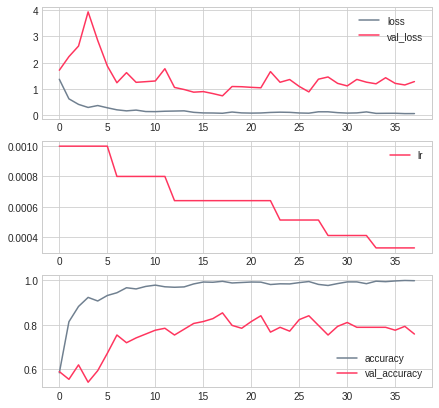

In [44]:
history_plot(history,7,c1)

In [45]:
model.load_weights(fw)
model.evaluate(rx_test0,ry_test0)

8/8 [==============================] - 0s 17ms/step - loss: 1.1292 - accuracy: 0.7586


[1.129194974899292, 0.7586206793785095]